In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 12.2 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 64.4 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 68.8 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 112 kB 58.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7816282617b2d026f33bbe9e277b35097fb2cabe288b5db89e71229bb0645514
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']

# 예측 데이터 사이즈
max_prediction_length = 20


# 학습용 데이터
# 전체 데이터의 70%만 사용
data_p = data.iloc[:int(data.index.max() * .7), :]
training_data = scaler.fit_transform(data_p[scale_cols])

# # 학습용 데이터
# data_p = data.iloc[:data.index.max() - max_prediction_length +1, :]
# training_data = scaler.fit_transform(data_p[scale_cols])

# max_prediction_length 만큼의 데이터는 예측 데이터와 비교를 위해 분리
actual_data = data.loc[~data.index.isin(data_p.index)][scale_cols]
actual_data.shape



(513, 1)

In [34]:
training_data.shape

(1194, 1)

In [35]:
data.shape

(1707, 2)

In [10]:
def sliding_windows(data, lookback_length, forecast_length):

    x = []
    y = []
    
    for i in range(lookback_length, len(data) - forecast_length + 1):
        _x = data[(i-lookback_length) : i]
        _y = data[i : (i + forecast_length)]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(X, y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = batch_size)

    val_ds = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    val_dl = DataLoader(val_ds, batch_size = batch_size)

    input_size = x_train.shape[-1]

    return train_dl, val_dl, input_size

In [11]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size * num_layers , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

In [12]:
def train(log_interval, model, train_dl, val_dl, optimizer, criterion, epoch):

    best_loss = np.inf
    for epoch in range(epoch):
        train_loss = 0.0
        model.train()
        for data, target in train_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                model = model.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) # mean-squared error for regression
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        valid_loss = 0.0
        model.eval()
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

        if ( epoch % log_interval == 0 ):
            print(f'\n Epoch {epoch} \t Training Loss: {train_loss / len(train_dl)} \t Validation Loss: {valid_loss / len(val_dl)} \n')

        if best_loss > (valid_loss / len(val_dl)):
            print(f'Validation Loss Decreased({best_loss:.6f}--->{(valid_loss / len(val_dl)):.6f}) \t Saving The Model')
            best_loss = (valid_loss / len(val_dl))
            torch.save(model.state_dict(), 'lstm_saved_model.pth')

    return best_loss


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [13]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size',[64, 128, 256, 512]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size', [16, 32, 64,128,256,512,1024]),
            'num_layers': trial.suggest_int('num_layers', 1, 5, 1) }

    torch.manual_seed(42)

    lookback_length = 90
    forecast_length = max_prediction_length
    log_interval = 10
    num_classes = 1 # parameter에서 빼서 상수로 설정
    num_epochs = 150 # parameter에서 빼서 상수로 설정

    x, y = sliding_windows(training_data, lookback_length, forecast_length)

    train_dl, val_dl, input_size = get_data_loader(x, y[:, 0, :],  cfg['batch_size'])
    model = LSTM(num_classes=num_classes, input_size=input_size, hidden_size=cfg['hidden_size'], num_layers=cfg['num_layers'])

    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()
    best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion,  num_epochs)

    # print('best loss for the trial = ', best_loss)
    predict_data = []
    actual_data = []

    # x_pred = x[-1:, :, :]  # last observed input sequence
    # y_pred = y[-1]         # last observed target value

    # 여기서 x는 (sample, lookback_length, 1)의 크기를 지님. 따라서, 제일 앞의 시점을 제거하려면, x[:, -1, :]이 되어야 함
    x_pred = x  # Inference에 사용할 lookback data를 x_pred로 지정. 앞으로 x_pred를 하나씩 옮겨 가면서 inference를 할 예정

    # print('-----------------------y shape before loop = ', y.shape)
    for j, i in enumerate(range(max_prediction_length - 1)):

        # feed the last forecast back to the model as an input
        # print(f'j = {j}')
        # print(f'y shape = {y.shape}')
        # print(f'Before update data = {x_pred.shape} & y_pred = {y_pred.shape}, expand_dim shape = {np.expand_dims(y[:, j, :], 1).shape}')
        x_pred = np.append(x_pred[:, 1:, :], np.expand_dims(y[:, j, :], 1), axis=1)

        # print(f'After update data = {x_pred.shape}')
        xt_pred = torch.Tensor(x_pred)

        if torch.cuda.is_available():
            xt_pred = xt_pred.cuda()

        # generate the next forecast
        yt_pred = model(xt_pred)

        # print(f'model result yt_pred = {yt_pred.shape}')
        # tensor to array
        # x_pred = xt_pred.cpu().detach().numpy()
        y_pred = yt_pred.cpu().detach().numpy()

        # save the forecast
        predict_data.append(y_pred)
        # save actual data
        actual_data.append(y[:, j, :])

     # print(f'After loop predict_data = {len(predict_data)} & predict_data = {len(predict_data)}')
    # transform the forecasts back to the original scale
    predict_data = np.array(predict_data).reshape(-1, 1)
    # predict_data = scaler.inverse_transform(predict_data) # actual_data는 scale되어 있는 데이터임
    actual_data = np.array(actual_data).reshape(-1, 1)

    # print(f'predict_data = {predict_data[:3]}, actual data = {actual_data[:3]}')
    # print(f'actual size = {actual.shape}, predict = {predict_data.shape}')
    SMAPE = smape(actual_data, predict_data)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [14]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()

# model.load_state_dict(torch.load('lstm_saved_model.pth'))
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=25)

[I 2022-06-17 02:53:03,196] A new study created in memory with name: no-name-31aa652f-d5aa-45dd-b85a-99bb42c8bae2



 Epoch 0 	 Training Loss: 0.029111374601987854 	 Validation Loss: 0.012294458458200097 

Validation Loss Decreased(inf--->0.012294) 	 Saving The Model
Validation Loss Decreased(0.012294--->0.010433) 	 Saving The Model
Validation Loss Decreased(0.010433--->0.009167) 	 Saving The Model
Validation Loss Decreased(0.009167--->0.008294) 	 Saving The Model
Validation Loss Decreased(0.008294--->0.007687) 	 Saving The Model
Validation Loss Decreased(0.007687--->0.007262) 	 Saving The Model
Validation Loss Decreased(0.007262--->0.006962) 	 Saving The Model
Validation Loss Decreased(0.006962--->0.006747) 	 Saving The Model
Validation Loss Decreased(0.006747--->0.006593) 	 Saving The Model
Validation Loss Decreased(0.006593--->0.006479) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.022568062837568244 	 Validation Loss: 0.006393431278411299 

Validation Loss Decreased(0.006479--->0.006393) 	 Saving The Model
Validation Loss Decreased(0.006393--->0.006328) 	 Saving The Model
Validation Loss Decr

[I 2022-06-17 02:53:51,251] Trial 0 finished with value: 86.25027691734313 and parameters: {'batch_size': 64, 'learning_rate': 0.00027136717806644186, 'hidden_size': 16, 'num_layers': 5}. Best is trial 0 with value: 86.25027691734313.


Validation Loss Decreased(0.003220--->0.003217) 	 Saving The Model
 
SMAPE : 86.25027691734313

 Epoch 0 	 Training Loss: 0.04333077766932547 	 Validation Loss: 0.010701923631131649 

Validation Loss Decreased(inf--->0.010702) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.01036230381578207 	 Validation Loss: 0.023058531805872917 


 Epoch 20 	 Training Loss: 0.006529561942443252 	 Validation Loss: 0.023228630423545837 


 Epoch 30 	 Training Loss: 0.0037690355093218386 	 Validation Loss: 0.03246232122182846 


 Epoch 40 	 Training Loss: 0.009051148488651961 	 Validation Loss: 0.013370991684496403 


 Epoch 50 	 Training Loss: 0.005988960852846503 	 Validation Loss: 0.01831463910639286 


 Epoch 60 	 Training Loss: 0.01904796389862895 	 Validation Loss: 0.03462719917297363 


 Epoch 70 	 Training Loss: 0.011528013739734888 	 Validation Loss: 0.01859818957746029 


 Epoch 80 	 Training Loss: 0.010632309364154935 	 Validation Loss: 0.018659837543964386 


 Epoch 90 	 Training Loss: 0.0

[I 2022-06-17 02:53:59,585] Trial 1 finished with value: 64.87771720962412 and parameters: {'batch_size': 512, 'learning_rate': 0.00667022038898804, 'hidden_size': 64, 'num_layers': 4}. Best is trial 1 with value: 64.87771720962412.


 
SMAPE : 64.87771720962412

 Epoch 0 	 Training Loss: 1112.5953434593976 	 Validation Loss: 2273.0830078125 

Validation Loss Decreased(inf--->2273.083008) 	 Saving The Model
Validation Loss Decreased(2273.083008--->466.305359) 	 Saving The Model
Validation Loss Decreased(466.305359--->216.264465) 	 Saving The Model
Validation Loss Decreased(216.264465--->96.766563) 	 Saving The Model

 Epoch 10 	 Training Loss: 150.63068008422852 	 Validation Loss: 178.6921844482422 

Validation Loss Decreased(96.766563--->92.160561) 	 Saving The Model
Validation Loss Decreased(92.160561--->47.747375) 	 Saving The Model
Validation Loss Decreased(47.747375--->36.184837) 	 Saving The Model
Validation Loss Decreased(36.184837--->36.010284) 	 Saving The Model
Validation Loss Decreased(36.010284--->32.359142) 	 Saving The Model
Validation Loss Decreased(32.359142--->19.757984) 	 Saving The Model

 Epoch 20 	 Training Loss: 21.207637786865234 	 Validation Loss: 14.929875373840332 

Validation Loss Decrease

[I 2022-06-17 02:54:11,537] Trial 2 finished with value: 114.14551986749865 and parameters: {'batch_size': 512, 'learning_rate': 0.5008245774923209, 'hidden_size': 128, 'num_layers': 4}. Best is trial 1 with value: 64.87771720962412.


 
SMAPE : 114.14551986749865

 Epoch 0 	 Training Loss: 0.03461551550675982 	 Validation Loss: 0.007283719489350915 

Validation Loss Decreased(inf--->0.007284) 	 Saving The Model
Validation Loss Decreased(0.007284--->0.006995) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.017810583048100983 	 Validation Loss: 0.008714356925338507 


 Epoch 20 	 Training Loss: 0.02163096546428278 	 Validation Loss: 0.007724469993263483 


 Epoch 30 	 Training Loss: 0.017191265609913638 	 Validation Loss: 0.0074939909391105175 

Validation Loss Decreased(0.006995--->0.006519) 	 Saving The Model
Validation Loss Decreased(0.006519--->0.005586) 	 Saving The Model

 Epoch 40 	 Training Loss: 0.010580029554798134 	 Validation Loss: 0.007960665505379438 


 Epoch 50 	 Training Loss: 0.009623845723191542 	 Validation Loss: 0.007404803531244397 


 Epoch 60 	 Training Loss: 0.008971908379213087 	 Validation Loss: 0.007533789845183492 


 Epoch 70 	 Training Loss: 0.007433711151991572 	 Validation Loss: 0.007

[I 2022-06-17 02:55:05,275] Trial 3 finished with value: 82.35671996926985 and parameters: {'batch_size': 128, 'learning_rate': 0.0003126224215409772, 'hidden_size': 256, 'num_layers': 5}. Best is trial 1 with value: 64.87771720962412.


 
SMAPE : 82.35671996926985

 Epoch 0 	 Training Loss: 0.02883132716773876 	 Validation Loss: 0.0045520864659920335 

Validation Loss Decreased(inf--->0.004552) 	 Saving The Model
Validation Loss Decreased(0.004552--->0.004083) 	 Saving The Model
Validation Loss Decreased(0.004083--->0.002181) 	 Saving The Model
Validation Loss Decreased(0.002181--->0.000309) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.0022979750350974166 	 Validation Loss: 0.001131705439547659 

Validation Loss Decreased(0.000309--->0.000238) 	 Saving The Model
Validation Loss Decreased(0.000238--->0.000219) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.0010843286298560478 	 Validation Loss: 0.0013642865233123302 

Validation Loss Decreased(0.000219--->0.000208) 	 Saving The Model
Validation Loss Decreased(0.000208--->0.000194) 	 Saving The Model
Validation Loss Decreased(0.000194--->0.000183) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.0009028060026789067 	 Validation Loss: 0.00042960439168382436 

Valid

[I 2022-06-17 02:55:18,894] Trial 4 finished with value: 60.33916997603149 and parameters: {'batch_size': 64, 'learning_rate': 0.003073317106297369, 'hidden_size': 16, 'num_layers': 1}. Best is trial 4 with value: 60.33916997603149.


 
SMAPE : 60.33916997603149

 Epoch 0 	 Training Loss: 0.030618557548483034 	 Validation Loss: 0.012990651783184148 

Validation Loss Decreased(inf--->0.012991) 	 Saving The Model
Validation Loss Decreased(0.012991--->0.011785) 	 Saving The Model
Validation Loss Decreased(0.011785--->0.007447) 	 Saving The Model
Validation Loss Decreased(0.007447--->0.007044) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.01756676605353797 	 Validation Loss: 0.00678622793930117 

Validation Loss Decreased(0.007044--->0.006786) 	 Saving The Model
Validation Loss Decreased(0.006786--->0.005463) 	 Saving The Model
Validation Loss Decreased(0.005463--->0.004313) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.015177740815228649 	 Validation Loss: 0.009285737876780331 

Validation Loss Decreased(0.004313--->0.002420) 	 Saving The Model
Validation Loss Decreased(0.002420--->0.002082) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.004091787007512592 	 Validation Loss: 0.0028418732108548284 


 Epoch 40 	

[I 2022-06-17 02:55:49,922] Trial 5 finished with value: 95.5909378573714 and parameters: {'batch_size': 64, 'learning_rate': 0.009970115340872564, 'hidden_size': 64, 'num_layers': 3}. Best is trial 4 with value: 60.33916997603149.


 
SMAPE : 95.5909378573714

 Epoch 0 	 Training Loss: 976.8677785098553 	 Validation Loss: 941.504150390625 

Validation Loss Decreased(inf--->941.504150) 	 Saving The Model
Validation Loss Decreased(941.504150--->600.306763) 	 Saving The Model
Validation Loss Decreased(600.306763--->55.543846) 	 Saving The Model
Validation Loss Decreased(55.543846--->48.290039) 	 Saving The Model

 Epoch 10 	 Training Loss: 70.38897514343262 	 Validation Loss: 160.84231567382812 

Validation Loss Decreased(48.290039--->48.030502) 	 Saving The Model
Validation Loss Decreased(48.030502--->36.927578) 	 Saving The Model
Validation Loss Decreased(36.927578--->23.749586) 	 Saving The Model
Validation Loss Decreased(23.749586--->14.629571) 	 Saving The Model

 Epoch 20 	 Training Loss: 14.389606475830078 	 Validation Loss: 11.814665794372559 

Validation Loss Decreased(14.629571--->11.814666) 	 Saving The Model
Validation Loss Decreased(11.814666--->9.554485) 	 Saving The Model
Validation Loss Decreased(9.55

[I 2022-06-17 02:55:59,994] Trial 6 finished with value: 84.61692565703285 and parameters: {'batch_size': 512, 'learning_rate': 0.5148536349587238, 'hidden_size': 128, 'num_layers': 3}. Best is trial 4 with value: 60.33916997603149.


 
SMAPE : 84.61692565703285

 Epoch 0 	 Training Loss: 0.20548953348770738 	 Validation Loss: 0.05845282971858978 

Validation Loss Decreased(inf--->0.058453) 	 Saving The Model
Validation Loss Decreased(0.058453--->0.004089) 	 Saving The Model
Validation Loss Decreased(0.004089--->0.001282) 	 Saving The Model
Validation Loss Decreased(0.001282--->0.000814) 	 Saving The Model
Validation Loss Decreased(0.000814--->0.000089) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.0005451728611660656 	 Validation Loss: 0.0008941452251747251 

Validation Loss Decreased(0.000089--->0.000086) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.00029372852623055223 	 Validation Loss: 7.650633779121563e-05 

Validation Loss Decreased(0.000086--->0.000077) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.0002797589436340786 	 Validation Loss: 8.211079693865031e-05 


 Epoch 40 	 Training Loss: 0.0002739250357990386 	 Validation Loss: 8.179077121894807e-05 


 Epoch 50 	 Training Loss: 0.00026907903793471

[I 2022-06-17 02:56:05,170] Trial 7 finished with value: 33.45010680557603 and parameters: {'batch_size': 256, 'learning_rate': 0.0830586299557716, 'hidden_size': 32, 'num_layers': 1}. Best is trial 7 with value: 33.45010680557603.


 
SMAPE : 33.45010680557603

 Epoch 0 	 Training Loss: 309.7156193293631 	 Validation Loss: 79.99197387695312 

Validation Loss Decreased(inf--->79.991974) 	 Saving The Model
Validation Loss Decreased(79.991974--->34.095425) 	 Saving The Model
Validation Loss Decreased(34.095425--->27.788855) 	 Saving The Model
Validation Loss Decreased(27.788855--->2.567224) 	 Saving The Model
Validation Loss Decreased(2.567224--->0.399669) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.23625800386071205 	 Validation Loss: 1.5040653944015503 

Validation Loss Decreased(0.399669--->0.016365) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.2998593896627426 	 Validation Loss: 0.8677756190299988 

Validation Loss Decreased(0.016365--->0.006247) 	 Saving The Model
Validation Loss Decreased(0.006247--->0.005501) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.17954180017113686 	 Validation Loss: 0.08702459931373596 

Validation Loss Decreased(0.005501--->0.003297) 	 Saving The Model

 Epoch 40 	 Trainin

[I 2022-06-17 02:57:02,863] Trial 8 finished with value: 69.83483972726661 and parameters: {'batch_size': 512, 'learning_rate': 0.03448117586412615, 'hidden_size': 1024, 'num_layers': 1}. Best is trial 7 with value: 33.45010680557603.


 
SMAPE : 69.83483972726661

 Epoch 0 	 Training Loss: 12.012861364121948 	 Validation Loss: 2.5411624908447266 

Validation Loss Decreased(inf--->2.541162) 	 Saving The Model
Validation Loss Decreased(2.541162--->0.015421) 	 Saving The Model
Validation Loss Decreased(0.015421--->0.005522) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.09510857648482281 	 Validation Loss: 0.1610674262046814 


 Epoch 20 	 Training Loss: 0.05155582570504131 	 Validation Loss: 0.014208137057721615 

Validation Loss Decreased(0.005522--->0.004922) 	 Saving The Model
Validation Loss Decreased(0.004922--->0.004251) 	 Saving The Model
Validation Loss Decreased(0.004251--->0.003727) 	 Saving The Model
Validation Loss Decreased(0.003727--->0.003339) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.019345026313593344 	 Validation Loss: 0.003092128419666551 

Validation Loss Decreased(0.003339--->0.003092) 	 Saving The Model
Validation Loss Decreased(0.003092--->0.003007) 	 Saving The Model

 Epoch 40 	 Traini

[I 2022-06-17 02:57:25,441] Trial 9 finished with value: 138.87861992836426 and parameters: {'batch_size': 64, 'learning_rate': 0.29406525415923634, 'hidden_size': 32, 'num_layers': 2}. Best is trial 7 with value: 33.45010680557603.


 
SMAPE : 138.87861992836426

 Epoch 0 	 Training Loss: 1.360689515247941 	 Validation Loss: 0.02022482641041279 

Validation Loss Decreased(inf--->0.020225) 	 Saving The Model
Validation Loss Decreased(0.020225--->0.001887) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.00563455639348831 	 Validation Loss: 0.012286832556128502 


 Epoch 20 	 Training Loss: 0.0030711407744092867 	 Validation Loss: 0.008410614915192127 


 Epoch 30 	 Training Loss: 0.002868502342607826 	 Validation Loss: 0.0077596390619874 


 Epoch 40 	 Training Loss: 0.002692326030228287 	 Validation Loss: 0.006917358376085758 


 Epoch 50 	 Training Loss: 0.0029457482451107353 	 Validation Loss: 0.008233347907662392 


 Epoch 60 	 Training Loss: 0.0027135493292007595 	 Validation Loss: 0.004426032770425081 


 Epoch 70 	 Training Loss: 0.0104841249412857 	 Validation Loss: 0.0036715264432132244 


 Epoch 80 	 Training Loss: 0.0027069425559602678 	 Validation Loss: 0.009382962249219418 


 Epoch 90 	 Training Loss: 

[I 2022-06-17 02:57:33,335] Trial 10 finished with value: 74.91523374180134 and parameters: {'batch_size': 256, 'learning_rate': 0.06873196655801943, 'hidden_size': 32, 'num_layers': 2}. Best is trial 7 with value: 33.45010680557603.


 
SMAPE : 74.91523374180134

 Epoch 0 	 Training Loss: 0.02094847447006032 	 Validation Loss: 0.003521205624565482 

Validation Loss Decreased(inf--->0.003521) 	 Saving The Model
Validation Loss Decreased(0.003521--->0.003125) 	 Saving The Model
Validation Loss Decreased(0.003125--->0.003057) 	 Saving The Model
Validation Loss Decreased(0.003057--->0.003029) 	 Saving The Model
Validation Loss Decreased(0.003029--->0.002803) 	 Saving The Model
Validation Loss Decreased(0.002803--->0.002533) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.011989462655037642 	 Validation Loss: 0.0022501382045447826 

Validation Loss Decreased(0.002533--->0.002250) 	 Saving The Model
Validation Loss Decreased(0.002250--->0.001975) 	 Saving The Model
Validation Loss Decreased(0.001975--->0.001711) 	 Saving The Model
Validation Loss Decreased(0.001711--->0.001450) 	 Saving The Model
Validation Loss Decreased(0.001450--->0.001173) 	 Saving The Model
Validation Loss Decreased(0.001173--->0.000853) 	 Saving Th

[I 2022-06-17 02:57:38,667] Trial 11 finished with value: 7.023413212837748 and parameters: {'batch_size': 256, 'learning_rate': 0.00243744167357133, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 7.023413212837748

 Epoch 0 	 Training Loss: 0.020430644450243562 	 Validation Loss: 0.003940597176551819 

Validation Loss Decreased(inf--->0.003941) 	 Saving The Model
Validation Loss Decreased(0.003941--->0.003421) 	 Saving The Model
Validation Loss Decreased(0.003421--->0.003229) 	 Saving The Model
Validation Loss Decreased(0.003229--->0.003166) 	 Saving The Model
Validation Loss Decreased(0.003166--->0.003162) 	 Saving The Model
Validation Loss Decreased(0.003162--->0.003116) 	 Saving The Model
Validation Loss Decreased(0.003116--->0.003018) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.014343225804623216 	 Validation Loss: 0.002885145600885153 

Validation Loss Decreased(0.003018--->0.002885) 	 Saving The Model
Validation Loss Decreased(0.002885--->0.002726) 	 Saving The Model
Validation Loss Decreased(0.002726--->0.002551) 	 Saving The Model
Validation Loss Decreased(0.002551--->0.002368) 	 Saving The Model
Validation Loss Decreased(0.002368--->0.002179) 	 Saving Th

[I 2022-06-17 02:57:44,141] Trial 12 finished with value: 7.6710563602122095 and parameters: {'batch_size': 256, 'learning_rate': 0.0017693541530254884, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


Validation Loss Decreased(0.000144--->0.000143) 	 Saving The Model
Validation Loss Decreased(0.000143--->0.000143) 	 Saving The Model
 
SMAPE : 7.6710563602122095

 Epoch 0 	 Training Loss: 0.0376974823884666 	 Validation Loss: 0.011514680460095406 

Validation Loss Decreased(inf--->0.011515) 	 Saving The Model
Validation Loss Decreased(0.011515--->0.010238) 	 Saving The Model
Validation Loss Decreased(0.010238--->0.007360) 	 Saving The Model
Validation Loss Decreased(0.007360--->0.007205) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.030618369637522846 	 Validation Loss: 0.01142826396971941 

Validation Loss Decreased(0.007205--->0.006512) 	 Saving The Model
Validation Loss Decreased(0.006512--->0.006246) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.017471651313826442 	 Validation Loss: 0.010115246288478374 


 Epoch 30 	 Training Loss: 0.013333288254216313 	 Validation Loss: 0.008950460702180862 

Validation Loss Decreased(0.006246--->0.004368) 	 Saving The Model
Validation Lo

[I 2022-06-17 02:58:33,052] Trial 13 finished with value: 68.09848964595648 and parameters: {'batch_size': 256, 'learning_rate': 0.0010840655996163758, 'hidden_size': 512, 'num_layers': 2}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 68.09848964595648

 Epoch 0 	 Training Loss: 0.020461182692088187 	 Validation Loss: 0.00391016760841012 

Validation Loss Decreased(inf--->0.003910) 	 Saving The Model
Validation Loss Decreased(0.003910--->0.003397) 	 Saving The Model
Validation Loss Decreased(0.003397--->0.003213) 	 Saving The Model
Validation Loss Decreased(0.003213--->0.003156) 	 Saving The Model
Validation Loss Decreased(0.003156--->0.003105) 	 Saving The Model
Validation Loss Decreased(0.003105--->0.002998) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.014217708492651582 	 Validation Loss: 0.0028552524745464325 

Validation Loss Decreased(0.002998--->0.002855) 	 Saving The Model
Validation Loss Decreased(0.002855--->0.002687) 	 Saving The Model
Validation Loss Decreased(0.002687--->0.002504) 	 Saving The Model
Validation Loss Decreased(0.002504--->0.002313) 	 Saving The Model
Validation Loss Decreased(0.002313--->0.002118) 	 Saving The Model
Validation Loss Decreased(0.002118--->0.001917) 	 Saving Th

[I 2022-06-17 02:58:38,405] Trial 14 finished with value: 7.600648154986115 and parameters: {'batch_size': 256, 'learning_rate': 0.0018104657931356074, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


Validation Loss Decreased(0.000142--->0.000142) 	 Saving The Model
 
SMAPE : 7.600648154986115

 Epoch 0 	 Training Loss: 0.023337301856372505 	 Validation Loss: 0.004281409550458193 

Validation Loss Decreased(inf--->0.004281) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.021398214914370328 	 Validation Loss: 0.0047963447868824005 


 Epoch 20 	 Training Loss: 0.020328092679847032 	 Validation Loss: 0.005513011943548918 


 Epoch 30 	 Training Loss: 0.01969782344531268 	 Validation Loss: 0.006155448965728283 


 Epoch 40 	 Training Loss: 0.019294802623335272 	 Validation Loss: 0.006659628823399544 


 Epoch 50 	 Training Loss: 0.019005838898010552 	 Validation Loss: 0.0070274039171636105 


 Epoch 60 	 Training Loss: 0.01877111312933266 	 Validation Loss: 0.007283995393663645 


 Epoch 70 	 Training Loss: 0.01855869876453653 	 Validation Loss: 0.007458132691681385 


 Epoch 80 	 Training Loss: 0.0183509488706477 	 Validation Loss: 0.007574126590043306 


 Epoch 90 	 Training Loss: 

[I 2022-06-17 02:58:46,299] Trial 15 finished with value: 65.82442955569304 and parameters: {'batch_size': 256, 'learning_rate': 0.00011911095214186437, 'hidden_size': 16, 'num_layers': 2}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 65.82442955569304

 Epoch 0 	 Training Loss: 0.022600098080667003 	 Validation Loss: 0.004776684567332268 

Validation Loss Decreased(inf--->0.004777) 	 Saving The Model
Validation Loss Decreased(0.004777--->0.004125) 	 Saving The Model
Validation Loss Decreased(0.004125--->0.003783) 	 Saving The Model
Validation Loss Decreased(0.003783--->0.003589) 	 Saving The Model
Validation Loss Decreased(0.003589--->0.003473) 	 Saving The Model
Validation Loss Decreased(0.003473--->0.003399) 	 Saving The Model
Validation Loss Decreased(0.003399--->0.003348) 	 Saving The Model
Validation Loss Decreased(0.003348--->0.003305) 	 Saving The Model
Validation Loss Decreased(0.003305--->0.003262) 	 Saving The Model
Validation Loss Decreased(0.003262--->0.003217) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.018109074062002555 	 Validation Loss: 0.0031654549529775977 

Validation Loss Decreased(0.003217--->0.003165) 	 Saving The Model
Validation Loss Decreased(0.003165--->0.003108) 	 Saving T

[I 2022-06-17 02:58:54,082] Trial 16 finished with value: 9.717228741628936 and parameters: {'batch_size': 128, 'learning_rate': 0.0007365177864819695, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 9.717228741628936

 Epoch 0 	 Training Loss: 0.07807017024606466 	 Validation Loss: 0.031304843723773956 

Validation Loss Decreased(inf--->0.031305) 	 Saving The Model
Validation Loss Decreased(0.031305--->0.008534) 	 Saving The Model
Validation Loss Decreased(0.008534--->0.007490) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.021645712971803732 	 Validation Loss: 0.006898697931319475 

Validation Loss Decreased(0.007490--->0.006899) 	 Saving The Model
Validation Loss Decreased(0.006899--->0.005984) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.010362251370679587 	 Validation Loss: 0.009098555892705917 

Validation Loss Decreased(0.005984--->0.005526) 	 Saving The Model
Validation Loss Decreased(0.005526--->0.004577) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.017496184795163572 	 Validation Loss: 0.007514478638768196 


 Epoch 40 	 Training Loss: 0.009594074741471559 	 Validation Loss: 0.007962759584188461 

Validation Loss Decreased(0.004577--->0.001695) 	 Savin

[I 2022-06-17 02:59:43,165] Trial 17 finished with value: 98.97780946325891 and parameters: {'batch_size': 256, 'learning_rate': 0.004011458282217028, 'hidden_size': 512, 'num_layers': 2}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 98.97780946325891

 Epoch 0 	 Training Loss: 21.228917613625526 	 Validation Loss: 12.509788513183594 

Validation Loss Decreased(inf--->12.509789) 	 Saving The Model
Validation Loss Decreased(12.509789--->6.274574) 	 Saving The Model
Validation Loss Decreased(6.274574--->1.059762) 	 Saving The Model
Validation Loss Decreased(1.059762--->0.897352) 	 Saving The Model
Validation Loss Decreased(0.897352--->0.308266) 	 Saving The Model

 Epoch 10 	 Training Loss: 6.929881930351257 	 Validation Loss: 1.2558940649032593 

Validation Loss Decreased(0.308266--->0.181670) 	 Saving The Model

 Epoch 20 	 Training Loss: 2.135420262813568 	 Validation Loss: 1.9266468286514282 

Validation Loss Decreased(0.181670--->0.136595) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.3949918672442436 	 Validation Loss: 0.237365260720253 

Validation Loss Decreased(0.136595--->0.125633) 	 Saving The Model
Validation Loss Decreased(0.125633--->0.073810) 	 Saving The Model
Validation Loss Decreased(0.

[I 2022-06-17 03:00:10,006] Trial 18 finished with value: 99.05855152559121 and parameters: {'batch_size': 256, 'learning_rate': 0.025547960067989626, 'hidden_size': 256, 'num_layers': 3}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 99.05855152559121

 Epoch 0 	 Training Loss: 0.030754232575418428 	 Validation Loss: 0.004567455034703016 

Validation Loss Decreased(inf--->0.004567) 	 Saving The Model
Validation Loss Decreased(0.004567--->0.002964) 	 Saving The Model
Validation Loss Decreased(0.002964--->0.002867) 	 Saving The Model
Validation Loss Decreased(0.002867--->0.000797) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.014315226348116994 	 Validation Loss: 0.002341603394597769 

Validation Loss Decreased(0.000797--->0.000336) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.004884657384536695 	 Validation Loss: 0.007187822367995977 


 Epoch 30 	 Training Loss: 0.0016282675642287359 	 Validation Loss: 0.0004780819872394204 

Validation Loss Decreased(0.000336--->0.000334) 	 Saving The Model

 Epoch 40 	 Training Loss: 0.0010467243337188847 	 Validation Loss: 0.00020917422079946846 

Validation Loss Decreased(0.000334--->0.000209) 	 Saving The Model
Validation Loss Decreased(0.000209--->0.000202) 	

[I 2022-06-17 03:01:20,508] Trial 19 finished with value: 8.755615723445256 and parameters: {'batch_size': 256, 'learning_rate': 0.0003833180129562478, 'hidden_size': 1024, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 8.755615723445256

 Epoch 0 	 Training Loss: 0.06976201904139348 	 Validation Loss: 0.03971212916076183 

Validation Loss Decreased(inf--->0.039712) 	 Saving The Model
Validation Loss Decreased(0.039712--->0.004338) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.012978409117619907 	 Validation Loss: 0.011673680040985346 


 Epoch 20 	 Training Loss: 0.004375089874624142 	 Validation Loss: 0.0096958689391613 


 Epoch 30 	 Training Loss: 0.004249941827895652 	 Validation Loss: 0.009323224425315857 


 Epoch 40 	 Training Loss: 0.004233377207128797 	 Validation Loss: 0.009035264141857624 


 Epoch 50 	 Training Loss: 0.004201944227263864 	 Validation Loss: 0.008626386988908052 


 Epoch 60 	 Training Loss: 0.004139461932936683 	 Validation Loss: 0.00794128654524684 


 Epoch 70 	 Training Loss: 0.004757786834878581 	 Validation Loss: 0.009090743493288755 


 Epoch 80 	 Training Loss: 0.003967066681070719 	 Validation Loss: 0.008580850437283516 


 Epoch 90 	 Training Loss: 0.

[I 2022-06-17 03:01:37,807] Trial 20 finished with value: 76.31448470621373 and parameters: {'batch_size': 128, 'learning_rate': 0.02037667907590272, 'hidden_size': 16, 'num_layers': 3}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 76.31448470621373

 Epoch 0 	 Training Loss: 0.020493665884714574 	 Validation Loss: 0.0038787173107266426 

Validation Loss Decreased(inf--->0.003879) 	 Saving The Model
Validation Loss Decreased(0.003879--->0.003372) 	 Saving The Model
Validation Loss Decreased(0.003372--->0.003196) 	 Saving The Model
Validation Loss Decreased(0.003196--->0.003147) 	 Saving The Model
Validation Loss Decreased(0.003147--->0.003093) 	 Saving The Model
Validation Loss Decreased(0.003093--->0.002976) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.01408273505512625 	 Validation Loss: 0.00282205524854362 

Validation Loss Decreased(0.002976--->0.002822) 	 Saving The Model
Validation Loss Decreased(0.002822--->0.002644) 	 Saving The Model
Validation Loss Decreased(0.002644--->0.002453) 	 Saving The Model
Validation Loss Decreased(0.002453--->0.002255) 	 Saving The Model
Validation Loss Decreased(0.002255--->0.002054) 	 Saving The Model
Validation Loss Decreased(0.002054--->0.001846) 	 Saving The

[I 2022-06-17 03:01:43,224] Trial 21 finished with value: 7.535636463005223 and parameters: {'batch_size': 256, 'learning_rate': 0.001853923926093596, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


Validation Loss Decreased(0.000141--->0.000141) 	 Saving The Model
 
SMAPE : 7.535636463005223

 Epoch 0 	 Training Loss: 0.020560587930958718 	 Validation Loss: 0.0038167594466358423 

Validation Loss Decreased(inf--->0.003817) 	 Saving The Model
Validation Loss Decreased(0.003817--->0.003325) 	 Saving The Model
Validation Loss Decreased(0.003325--->0.003166) 	 Saving The Model
Validation Loss Decreased(0.003166--->0.003132) 	 Saving The Model
Validation Loss Decreased(0.003132--->0.003064) 	 Saving The Model
Validation Loss Decreased(0.003064--->0.002925) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.013799495063722134 	 Validation Loss: 0.0027493592351675034 

Validation Loss Decreased(0.002925--->0.002749) 	 Saving The Model
Validation Loss Decreased(0.002749--->0.002552) 	 Saving The Model
Validation Loss Decreased(0.002552--->0.002345) 	 Saving The Model
Validation Loss Decreased(0.002345--->0.002134) 	 Saving The Model
Validation Loss Decreased(0.002134--->0.001920) 	 Saving 

[I 2022-06-17 03:01:48,740] Trial 22 finished with value: 7.420230700405184 and parameters: {'batch_size': 256, 'learning_rate': 0.0019426165290821775, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


Validation Loss Decreased(0.000140--->0.000140) 	 Saving The Model
Validation Loss Decreased(0.000140--->0.000140) 	 Saving The Model
Validation Loss Decreased(0.000140--->0.000140) 	 Saving The Model
Validation Loss Decreased(0.000140--->0.000140) 	 Saving The Model
 
SMAPE : 7.420230700405184

 Epoch 0 	 Training Loss: 0.025975258788093925 	 Validation Loss: 0.0055712563917040825 

Validation Loss Decreased(inf--->0.005571) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.01381274580489844 	 Validation Loss: 0.008133355528116226 


 Epoch 20 	 Training Loss: 0.003418389882426709 	 Validation Loss: 0.007772123906761408 


 Epoch 30 	 Training Loss: 0.00263979679584736 	 Validation Loss: 0.007882226258516312 


 Epoch 40 	 Training Loss: 0.0024878742697183043 	 Validation Loss: 0.00763020059093833 


 Epoch 50 	 Training Loss: 0.0023583155270898715 	 Validation Loss: 0.00726376473903656 


 Epoch 60 	 Training Loss: 0.002242230490082875 	 Validation Loss: 0.006992135662585497 


 Epoch

[I 2022-06-17 03:01:56,692] Trial 23 finished with value: 76.46287008437963 and parameters: {'batch_size': 256, 'learning_rate': 0.004497108022945475, 'hidden_size': 16, 'num_layers': 2}. Best is trial 11 with value: 7.023413212837748.


 
SMAPE : 76.46287008437963

 Epoch 0 	 Training Loss: 0.019690864835865796 	 Validation Loss: 0.005042002070695162 

Validation Loss Decreased(inf--->0.005042) 	 Saving The Model
Validation Loss Decreased(0.005042--->0.004577) 	 Saving The Model
Validation Loss Decreased(0.004577--->0.004262) 	 Saving The Model
Validation Loss Decreased(0.004262--->0.004032) 	 Saving The Model
Validation Loss Decreased(0.004032--->0.003861) 	 Saving The Model
Validation Loss Decreased(0.003861--->0.003730) 	 Saving The Model
Validation Loss Decreased(0.003730--->0.003630) 	 Saving The Model
Validation Loss Decreased(0.003630--->0.003553) 	 Saving The Model
Validation Loss Decreased(0.003553--->0.003493) 	 Saving The Model
Validation Loss Decreased(0.003493--->0.003444) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.017214625142514706 	 Validation Loss: 0.0034040934406220913 

Validation Loss Decreased(0.003444--->0.003404) 	 Saving The Model
Validation Loss Decreased(0.003404--->0.003370) 	 Saving T

[I 2022-06-17 03:02:02,097] Trial 24 finished with value: 12.921025228029492 and parameters: {'batch_size': 256, 'learning_rate': 0.0006705430330850013, 'hidden_size': 16, 'num_layers': 1}. Best is trial 11 with value: 7.023413212837748.


Validation Loss Decreased(0.000316--->0.000314) 	 Saving The Model
Validation Loss Decreased(0.000314--->0.000312) 	 Saving The Model
Validation Loss Decreased(0.000312--->0.000310) 	 Saving The Model
Validation Loss Decreased(0.000310--->0.000308) 	 Saving The Model
 
SMAPE : 12.921025228029492


In [16]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220617_01.pkl')

['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220617_01.pkl']

In [ ]:
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220615_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  5.477795508716941
 Params: 
    max_epochs: 50
    learning_rate: 0.005659123649008913
    hidden_size: 256


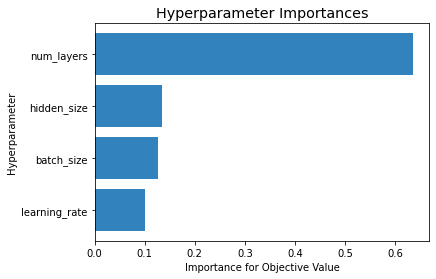

In [17]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

Number of finished trials:  25
Best trial:
  Value:  7.023413212837748
  Params: 
    batch_size: 256
    learning_rate: 0.00243744167357133
    hidden_size: 16
    num_layers: 1


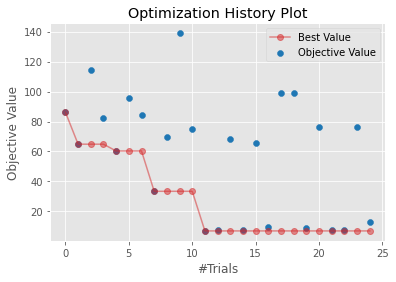

In [18]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()


optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## Plot Results

In [50]:
torch.manual_seed(42)

lookback_length = 90
forecast_length = max_prediction_length
log_interval = 10
num_classes = 1 
num_epochs = 150 



x, y = sliding_windows(training_data, lookback_length, forecast_length)

train_dl, val_dl, input_size = get_data_loader(x, y[:, 0, :],  study.best_params['batch_size'])
model = LSTM(num_classes=num_classes, input_size=input_size, hidden_size=study.best_params['hidden_size'], num_layers=study.best_params['num_layers'])

if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()
best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion,  num_epochs)

# print('best loss for the trial = ', best_loss)
predict_data = []
actual_data = []

# x_pred = x[-1:, :, :]  # last observed input sequence
# y_pred = y[-1]         # last observed target value

# 여기서 x는 (sample, lookback_length, 1)의 크기를 지님. 따라서, 제일 앞의 시점을 제거하려면, x[:, -1, :]이 되어야 함
x_pred = x  # Inference에 사용할 lookback data를 x_pred로 지정. 앞으로 x_pred를 하나씩 옮겨 가면서 inference를 할 예정

# print('-----------------------y shape before loop = ', y.shape)
for j, i in enumerate(range(max_prediction_length - 1)):

    # feed the last forecast back to the model as an input
    # print(f'j = {j}')
    # print(f'y shape = {y.shape}')
    # print(f'Before update data = {x_pred.shape} & y_pred = {y_pred.shape}, expand_dim shape = {np.expand_dims(y[:, j, :], 1).shape}')
    x_pred = np.append(x_pred[:, 1:, :], np.expand_dims(y[:, j, :], 1), axis=1)

    # print(f'After update data = {x_pred.shape}')
    xt_pred = torch.Tensor(x_pred)

    if torch.cuda.is_available():
        xt_pred = xt_pred.cuda()

    # generate the next forecast
    yt_pred = model(xt_pred)

    # print(f'model result yt_pred = {yt_pred.shape}')
    # tensor to array
    # x_pred = xt_pred.cpu().detach().numpy()
    y_pred = yt_pred.cpu().detach().numpy()

    # save the forecast
    predict_data.append(y_pred)
    print(f'predict_data : {predict_data}')
    # save actual data
    actual_data.append(y[:, j, :])

# print(f'After loop predict_data = {len(predict_data)} & predict_data = {len(predict_data)}')
# transform the forecasts back to the original scale
predict_data_np = np.array(predict_data).reshape(-1, 1)
# predict_data = scaler.inverse_transform(predict_data) # actual_data는 scale되어 있는 데이터임
actual_data_np = np.array(actual_data).reshape(-1, 1)

# # print(f'predict_data = {predict_data[:3]}, actual data = {actual_data[:3]}')
# # print(f'actual size = {actual.shape}, predict = {predict_data.shape}')
# SMAPE = smape(actual_data, predict_data)
# print(f' \nSMAPE : {SMAPE}')


# pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict_data, columns=['trade_price'])], axis=0).reset_index(drop=True)
# pred_df = pred_df.rename(columns = {'trade_price':'pred_price'})
# data_df = pd.concat([data, pred_df], axis=1)

# plt.plot(data_df['pred_price'][len(data_df)-lookback_length*3:], label='prediction')
# plt.plot(data_df['trade_price'][len(data_df)-lookback_length*3:], label='actual')
# plt.suptitle('Timeseries Prediction')
# plt.suptitle('Timeseries Prediction')
# plt.axvline(x = len(data_df) - len(predict_data), c = 'g', linestyle = '--')
# plt.legend()
# plt.show();


np.expand_dims(y[:, 9, :], 1).shape



 Epoch 0 	 Training Loss: 0.02094847447006032 	 Validation Loss: 0.003521205624565482 

Validation Loss Decreased(inf--->0.003521) 	 Saving The Model
Validation Loss Decreased(0.003521--->0.003125) 	 Saving The Model
Validation Loss Decreased(0.003125--->0.003057) 	 Saving The Model
Validation Loss Decreased(0.003057--->0.003029) 	 Saving The Model
Validation Loss Decreased(0.003029--->0.002803) 	 Saving The Model
Validation Loss Decreased(0.002803--->0.002533) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.011989462655037642 	 Validation Loss: 0.0022501382045447826 

Validation Loss Decreased(0.002533--->0.002250) 	 Saving The Model
Validation Loss Decreased(0.002250--->0.001975) 	 Saving The Model
Validation Loss Decreased(0.001975--->0.001711) 	 Saving The Model
Validation Loss Decreased(0.001711--->0.001450) 	 Saving The Model
Validation Loss Decreased(0.001450--->0.001173) 	 Saving The Model
Validation Loss Decreased(0.001173--->0.000853) 	 Saving The Model
Validation Loss Decr

(1085, 1, 1)

In [51]:
np.expand_dims(y[:, 9, :], 1).shape


(1085, 1, 1)

In [49]:
np.array(predict_data).shape

(19, 1085, 1)

In [27]:
pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict_data, columns=['trade_price'])], axis=0).reset_index(drop=True)

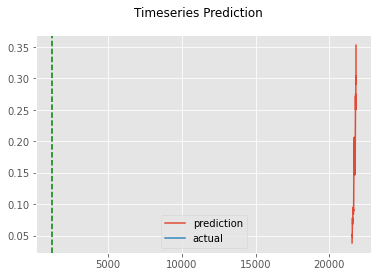

In [24]:
pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict_data, columns=['trade_price'])], axis=0).reset_index(drop=True)
pred_df = pred_df.rename(columns = {'trade_price':'pred_price'})
data_df = pd.concat([data, pred_df], axis=1)

plt.plot(data_df['pred_price'][len(data_df)-lookback_length*3:], label='prediction')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length*3:], label='actual')
plt.suptitle('Timeseries Prediction')
plt.axvline(x = len(data_df) - len(predict_data), c = 'g', linestyle = '--')
plt.legend()
plt.show();

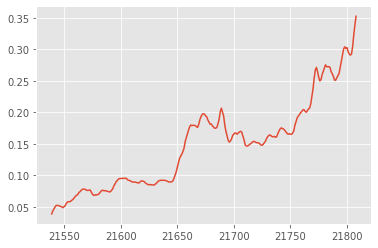

In [26]:
plt.plot(data_df['pred_price'][len(data_df)-lookback_length*3:], label='prediction')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length*3:], label='actual')

NameError: ignored

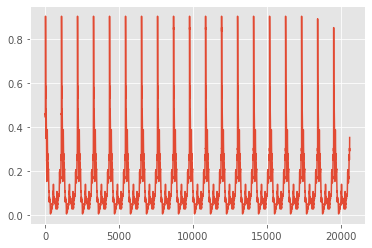

In [23]:
plt.plot(predict_data, label='predict')
plt.plot(actual, label='actual')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show();

In [ ]:
t1 = pd.DataFrame(predict, columns=['predict'])
t2 = pd.DataFrame(actual, columns=['actual'])

pd.concat([t1,t2], axis=1)

,predict,actual
0,3031235.50,3038000.0
1,2902678.75,3095000.0
2,2805710.75,2884000.0
3,2724697.00,2648000.0
4,2654125.50,2694000.0
5,2593605.75,2733000.0
6,2542449.50,2806000.0
7,2498977.50,2660000.0
8,2461608.75,2695000.0
9,2429323.50,2472000.0


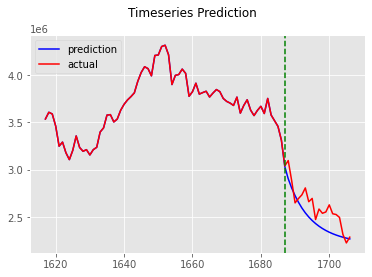

In [ ]:
plt.plot(data_df['pred_price'][len(data_df)-lookback_length:], label='prediction', c = 'blue')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length:], label='actual', c = 'red')
plt.suptitle('Timeseries Prediction')
plt.suptitle('Timeseries Prediction')
plt.axvline(x = len(data_df) - len(predict), c = 'g', linestyle = '--')
plt.legend()
plt.show();